This dataset's been downloaded from Kaggle (link: https://www.kaggle.com/cherngs/heart-disease-cleveland-uci) and the columns descriptions are as following:

There are 13 attributes:


**age**: age (in years)


**sex**: gender (1 = male; 0 = female)


**cp**: chest pain type

There are three criteria for classifying different types of angina (chest pain) under three categories (according to this NCBI paper: https://pubmed.ncbi.nlm.nih.gov/20494662/):

◼ *Location*: Chest pain occurs around the substernal portion of the body

◼ *Cause*: Pain is experienced after induction of emotional/physical stress

◼ *Relief*: The pain goes away after taking nitroglycerine and/or a rest

-- 0: typical angina (all criteria present)

-- 1: atypical angina (two of three criteria satisfied)

-- 2: non-anginal pain (less than one criteria satisfied)

-- Value 3: asymptomatic (none of the criteria are satisfied)


**trestbps**: resting blood pressure (in mmHg, upon admission to the hospital)


**chol**: serum cholesterol in mg/dL


**fbs**: fasting blood sugar > 120 mg/dL (likely to be diabetic) 1 = true; 0 = false


**restecg**: resting electrocardiogram results

-- Value 0: normal

-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) - more on the effects of these below

-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria


**thalach**: maximum heart rate achieved


**exang**: exercise induced angina (1 = yes; 0 = no)


**oldpeak**: ST depression induced by exercise relative to rest (in mm, achieved by subtracting the lowest ST segment points during exercise and rest)


**slope**: the slope of the peak exercise ST segment, ST-T abnormalities are considered to be a crucial indicator for identifying presence of ischaemia (according to this research paper on NCBI: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7027664/)


#### Depressed ST segment ECG results by slope direction

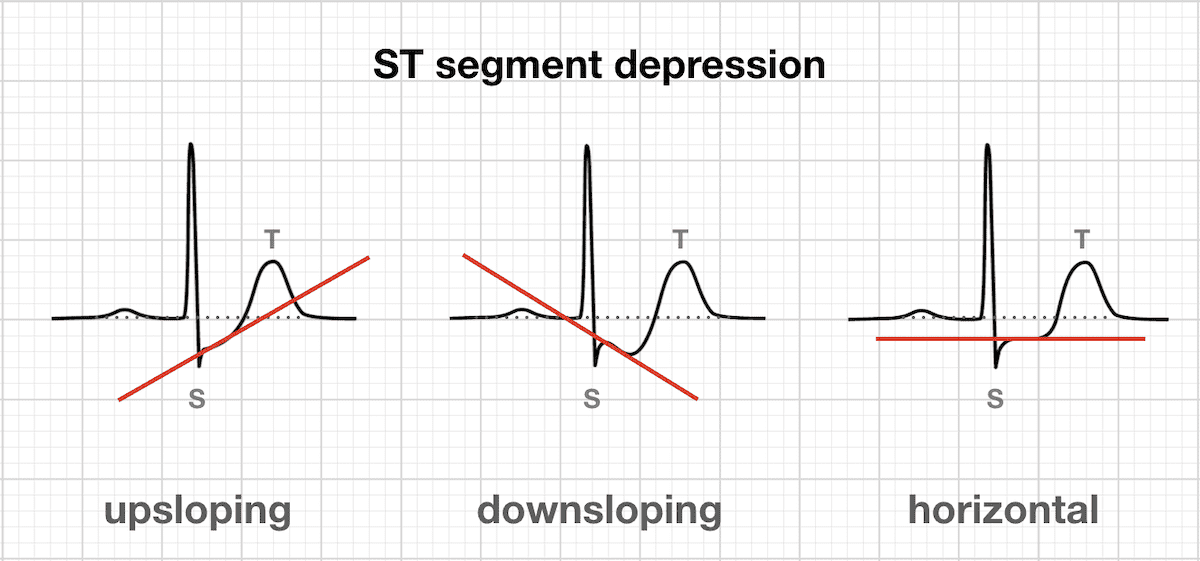 

(image is taken from this article on litfl.com: https://litfl.com/myocardial-ischaemia-ecg-library/)

#### ST segment and T wave abnormalities vs. normal ST segment

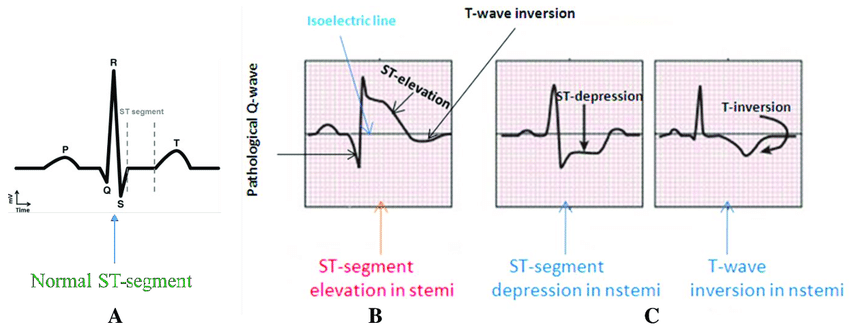

(image is taken from this paper on ResearchGate: https://www.researchgate.net/publication/333912486_Wearable_Real-Time_Heart_Attack_Detection_and_Warning_System_to_Reduce_Road_Accidents)

-- Value 0: upsloping

-- Value 1: flat

-- Value 2: downsloping


**ca**: number of major vessels (0-3) colored by fluoroscopy. Major cardial vessels are as goes: aorta, superior vena cava, inferior vena cava, pulmonary artery (oxygen-poor blood --> lungs), pulmonary veins (oxygen-rich blood --> heart), and coronary arteries (supplies blood to heart tissue).

Radioactive dye is introduced to the body followed by x-ray imaging to detect any structural abnormalities present in the heart. The quantity of vessels colored is positively correlated with presence of heart disease.


**thal**: 0 = normal; 1 = fixed defect (heart tissue can't absorb thallium both under stress and in rest); 2 = reversible defect (heart tissue is unable to absorb thallium only under the exercise portion of the test)

Thallium testing is a method where the radioactive element thallium (Tl) is introduced to the body through an IV injection, followed by nuclear imaging of the heart with a gamma camera which reveals structural issues and abnormalities of the heart by showing whether if the isotope was absorbed by heart tissue under high (exercise) and low (rest) stress conditions.


**condition**: 0 = no disease, 1 = disease

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

In [ ]:
warnings.simplefilter(action='ignore')
df = pd.read_csv("../input/heart-disease-cleveland-uci/heart_cleveland_upload.csv")
df.head()

## Basic EDA and visualizations

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
sns.set_context("talk")
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, fmt=".2f")

The above graph is a matrix that shows the correlation of all the columns in the dataset. It's a intuitive method for visualizing the presence of linear relationships for datasets containing relatively fewer features epspecially. However it must be noted that this particular dataset is mostly made up of categorical features, therefore most of the correlation coefficients in the above graph won't make sense, especially for points that contain a non-binary categorical feature. 

In [ ]:
df.groupby("condition")[["thalach","chol","age","trestbps"]].mean()

I selected all of the numerical columns, took their average, and grouped them by our target column, "condition". 

* It appears that the average age of the cases that present with a heart condition were ~4 years younger on average than the people who admitted without a heart disease.  

* A somewhat significant difference is apparent between the maximum heart rates of people who are sick and healthy, since healthy people were able to reach a 20 beats per minute higher maximum heart rate on average compared to those who are ill. 

* Those who weren't sick had a lower resting heart rate compared to ill people, however this difference is not that significant (especially compared to the difference between the patients' maximal heart rate) and differs merely by 6 beats per minute on average.

* Finally, people without a heart disease had a lower cholesterol count of ~8 mg/dL in their blood serum on average compared to cases that presented with a heart disease.

In [ ]:
#Histogram of age distribution
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(12, 9))
sns.histplot(data=df["age"], alpha=0.6)
plt.axvline(df["age"].mean(), color="red")
plt.title("Distribution of age in the dataset")
plt.text(33, 42, "Mean age: " + str(round(df["age"].mean(), 1)), color="indianred", weight="heavy", size="larger", bbox=dict(boxstyle="round", color="rosybrown"))
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Distribution of age in the dataset is somewhat normal-like and the average age is 54.5. 

In [ ]:
#Histogram of ST depression distribution
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(12, 9))
sns.histplot(data=df["oldpeak"], alpha=0.6)
plt.title("Relative ST depression (Exercise-Rest, mm)")
plt.xlabel("Difference (Exercise-Rest, mm)")
plt.ylabel("Count")
plt.show()

Most of the samples fall between a range of 0-2 millimeters' difference regarding the bottom-most points of ST segment depressions in ECG charts as the plot above shows. A difference of 2mm was used as a threshold to interrupt stress testing in this (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1768611/) paper, therefore it's possible to argue that the values that go above this range should be treated as anomalies.

In [ ]:
#I had to create a new column since Seaborn gave me some trouble with proper legend labeling, it's not essential
df["Heart condition"] = df["condition"].replace({1:"Present", 0:"Not present"})

#Part concerning the actual plotting
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(12, 9))
sns.scatterplot("chol", "age", hue=df["Heart condition"], data=df)
plt.title("Cases presenting heart disease compared by their age and blood cholesterol")
plt.xlabel("Blood cholesterol (mg/dL)")
plt.ylabel("Age")
plt.show()

In [ ]:
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(12, 9))
sns.scatterplot("thalach", "age", hue=df["Heart condition"], data=df)
plt.title("Maximum heart rate achieved by presence of heart condition and distribution of age")
plt.xlabel("Maximum heart rate (beats per minute)")
plt.ylabel("Age")
plt.show()

There's a slight skewing (or clustering) towards the right side of the plot for healthy individuals, meaning individuals that were able to achieve higher maximum heart rates might be more likely to have a healthy heart. It should also be noted that younger individuals could reach higher heart beats per minute, meaning there's an inverse relationship between age and maximum heart rate. 

In [ ]:
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(12, 9))
sns.scatterplot("trestbps", "age", hue=df["Heart condition"], data=df)
plt.title("Change of rest heart bpm by age")
plt.xlabel("Resting heart rate (beats per minute)")
plt.ylabel("Age")
plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
g = sns.countplot("exang", hue="slope", data=df)
g.set_xticklabels(["Not present", "Present"])
plt.title("Presence of exercise induced angina by the slope's direction on peak of the ST segment")
plt.xlabel("Presence of exercise induced angina")
plt.ylabel("Counts")
plt.legend(["Upsloping", "Flat", "Downsloping"])
plt.show()

According to this (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1123032/) article on PubMed: "...The normal ST segment during exercise therefore slopes sharply upwards..."

So simply put, the ST segment slope is expected to be upsloping for healthy individuals during effort testing.

In [ ]:
plt.figure(figsize=(12, 9))
g = sns.countplot("cp", hue="sex", data=df)
g.set_xticklabels(["Typical", "Atypical", "Non-Anginal", "Asymptomatic"])
plt.title("Distribution of anginal pain type by gender")
plt.xlabel("Anginal pain type")
plt.ylabel("Count")
plt.legend(["Female", "Male"])
plt.show()

In [ ]:
plt.figure(figsize=(20, 9))
g = sns.countplot(pd.cut(df["oldpeak"], 13), hue="Heart condition", data=df) #I had to bin the x values since there were too many distinct values to interprete
plt.title("Difference ST segment depression (Exercise-Rest) by presence of heart disease")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.legend(["Not present", "Present"])
plt.show()

While this might not be the most aesthetic looking plot ever, it clearly shows that the incidence of heart disease presence and difference of ST segment depression during exercise-rest move in the same direction, meaning that as the difference of ST segment depression during exercise against depression during rest gets larger, more likely it gets to encounter a person with heart disease.

## Binning continous numeric values

In [ ]:
#Binning continous features together and therefore creating discrete categorical columns could 
#help the model to generalize the data and reduce overfitting
df["thalach"] = pd.cut(df["thalach"], 8, labels=range(1, 9))
df["trestbps"] = pd.cut(df["trestbps"], 5, labels=range(8, 13))
df["age"] = pd.cut(df["age"], 12, labels=range(12, 24))
df["chol"] = pd.cut(df["chol"], 10, labels=range(24, 34))
df["oldpeak"] = pd.cut(df["oldpeak"], 5, labels=range(34, 39))

I converted all the continous values into categorical ones by binning them. The model is able to interprete the distributed weights of a particular feature when "there are less options to choose from" regarding observations.

## One-hot encoding categorical values

In [ ]:
a = pd.get_dummies(df, columns=["cp", "restecg", "slope", "thalach", "trestbps", "age", "chol", "thal", "oldpeak"], 
                   prefix=["cp", "restecg", "slope", "thalach", "trestbps", "age", "chol", "thal", "oldpeak"], drop_first=True)

It's important to encode the categorical features since the model will otherwise treat the numbers that represent categories as weights instead, this could create the risk of the model capturing non-existent relationships between the features. I used one hot encoding with pandas by setting the drop_first argument to True.

In [ ]:
a = a.drop("Heart condition", axis=1)

I also dropped the renamed condition column that I used for proper legend labeling above on the graphs.

In [ ]:
a.head()

## Determining feature importances

In [ ]:
rf = RandomForestClassifier()
rf.fit(a.drop("condition", axis=1), a.condition)
importances = rf.feature_importances_
features = pd.Series(importances, index=a.drop("condition", axis=1).columns)
plt.figure(figsize=(12, 16))
features.plot(kind="barh")
plt.show()

I used a Random Forest Classifier in order to determine feature importances and plotted them. 

## Building the model and hyperparameter tuning

In [ ]:
X = a.drop(["condition", "restecg_1", "thalach_2", "thalach_8", "trestbps_12", "age_13", "age_22", "age_23", 
            "chol_29", "chol_30", "chol_31", "chol_32", "chol_33", "oldpeak_37", "oldpeak_38"], axis=1)
y = a.condition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#It took forever for Kaggle's kernel to run GridSearchCV with xGBoosting, however I added the results
#of hyperparameter tuning as markdown cells below.

#xgb = xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc")
#params = {"max_depth":np.arange(1, 8), "n_estimators":[100, 300, 500, 600, 900, 1000], 
#          "learning_rate":[0.001, 0.01, 0.03, 0.05, 0.07], "colsample_bytree":[0.35, 0.5, 0.65],
#          "subsample":[0.4, 0.5, 0.55, 0.7]
#          }
#grid_xgb = GridSearchCV(estimator = xgb, param_grid = params, cv=10, n_jobs=-1)
#grid_xgb.fit(X_train, y_train)
#xgb_pred = grid_xgb.predict(X_test)
#print(classification_report(y_test, xgb_pred))

In [ ]:
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", max_depth=1,
                    n_estimators=500,learning_rate=0.05,colsample_bytree=0.35,subsample=0.5)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

I dropped the target ("condition") column and all the feature columns that had a relatively lower importance percentage (such as the columns "chol_31" and "chol_32 which weren't been used at all by the model to split nodes) in order to reduce noise and overfitting. I used 80% of the data as to train the model and the remaining 20% for testing, and also included the stratify argument in order to make sure that both the training and validation sets have equal percentages of individuals that *do* present with heart disease and don't. Finally, I used GridSearchCV to tune hyperparameters, using 10-fold cross validation during the process.

## Evaluation of the model

In [ ]:
print(grid_xgb.best_params_)

{'colsample_bytree': 0.35, 'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 500, 'subsample': 0.5}

In [ ]:
print(grid_xgb.cv_results_["mean_test_score"].mean())

0.8079008511617207

In [ ]:
print(classification_report(y_test, xgb_pred))

Model producing the best result has a 90% weighted average accuracy score, whereas this accuracy score drops down to ~81% when the scores of 10 cross validation splits of the training and test data are averaged. A difference of 8% between the accuracy scores of the best scoring model and mean of the accuracy scores provided by 10 different train/test splits plugged into a tuned model indicates the presence of a somewhat significant case of overfitting.

In [ ]:
sns.set_context("talk")
plt.figure(figsize=(12, 9))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, xticklabels=["Healthy", "Sick"], yticklabels=["Healthy", "Sick"], fmt="g", cmap="icefire_r")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Confusion matrix of xGBoosting")
plt.show()

In [ ]:
xgb_prob = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_prob)
sns.set_style("darkgrid")
sns.set_context("poster")
plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0, 1], 'k--')
sns.lineplot(fpr, tpr, alpha=0.6, ci=None)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(["Baseline", "xGBoosting"])
plt.show()
print(roc_auc_score(y_test, xgb_prob))

## Conclusion

Feeding the model with ideal parameters and a favorable train-test split resulted in an AUC score of 0.97. The model seems to be especially potent at detecting healthy people, considering that only 2 people out of 26 were mislabeled as healthy despite being ill. Efficiency of the model does drop a bit compared to predicting "healthiness" when it comes to determining whether if an individual is sick or not, however a high false positive rate could be a preferrable trade-off in order to achieve a low false negative count, considering that the priority is to ensure that the model detects as many sick people as possible. Considered that the model's recall is still in a somewhat decent range, it could be argued that this specific model could actually be deployed and be of use in practice.